In [74]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from src.eegnet import EEGNet
from src.dataloading import DataLoader
from src.preprocessing import Preprocesser

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

import tensorflow as tf
tf.keras.utils.set_random_seed(42)

# Get Data

In [76]:
dataloader = DataLoader(path_to_data="../data/raw/P01")
df_list: list[pd.DataFrame] = dataloader.load_data()

2024-01-22 10:55:16,263 - src.dataloading - INFO - Found 10 .csv files in input path '../data/raw/P01' ...
2024-01-22 10:55:32,344 - src.dataloading - INFO - Parsed 10 .csv files into DataFrames ...


In [77]:
CONDITIONS =  ["MathxHard"] #["MathxEasy", "MathxMedium", "MathxHard"]
PERCENTAGE_OF_SYNTHESIZED_DATA_TO_POPULATE_TRAIN = 1  # Float Value in [0, 1.0]
N_RUNS: int = 25
N_EPOCHS: int = 32

pp_data = {}

for i, condition in enumerate(CONDITIONS):
    preprocessor = Preprocesser(df_list=df_list, condition=condition, partition_size=250, fixed_size=11000)
    tensor: np.array = preprocessor.preprocess_data()
    FEATURE_NAMES = list(preprocessor.df_list_processed[0].columns)

    pp_data[condition] = {
        "tensor": tensor,
        "y_list": preprocessor.y_list_processed,
        "condition": condition,
        "condition_encoded": i,
        "condition_df": pd.DataFrame([condition for n in range(0, tensor.shape[0])]),
        "condition_encoded_df": pd.DataFrame([i for n in range(0, tensor.shape[0])]),
        "feature_names": FEATURE_NAMES,
        "scaler_object": preprocessor.scaler
    }

# Stack data of each condition to one single 3D numpy array (input data to model)
tensor = np.concatenate([pp_data[key]["tensor"] for key in pp_data.keys()], axis=0)
y_tensor = np.concatenate([pp_data[key]["y_list"] for key in pp_data.keys()], axis=0)
conditions = pd.concat(pp_data[key]["condition_df"] for key in pp_data.keys())

# Get Labels in Shape (1290 x 1), i.e. (Number of Samples, Dimension_Label)
y_label_list = []
for i in range(0, y_tensor.shape[0]):
    y = y_tensor[i][0]
    y_label_list.append(y)
y_label = np.array(y_label_list)

# Discretize labels
def _discretize_target(val: float) -> np.array:
    """ Call this function via np.vectorize(_discretize_target)(y_label) """
    if val < 0.1:
        return 0
    elif 0.1 <= val < 0.3:
        return 1
    else:
        return 2

classes = np.vectorize(_discretize_target)(y_label)

2024-01-22 10:55:32,592 - src.preprocessing - INFO - Starting preprocessing pipeline (Condition: MathxHard, Partition Size: 250, Fixed Size: 11000) ...
2024-01-22 10:55:32,754 - src.preprocessing - INFO - Stacking data to 3D tensor ...
2024-01-22 10:55:32,762 - src.preprocessing - INFO - Finished preprocessing pipeline (Duration: 0.17s) ...



In [78]:
print(f"Shape of Input Data: {tensor.shape}")
print(f"Shape of condition_df: {conditions.shape}")
print(f"Shape of Labels: {y_tensor.shape}")

Shape of Input Data: (440, 250, 7)
Shape of condition_df: (440, 1)
Shape of Labels: (440, 250, 1)


In [79]:
len(y_label_list)

440

# Train Test Split

In [80]:
from sklearn.model_selection import train_test_split
# Train Test Split
train_ind, test_ind = train_test_split(list(range(tensor.shape[0])), test_size=0.33, random_state=42)
X_train = tensor[train_ind, :, :]
y_train = classes[train_ind, :]
X_test = tensor[test_ind, :, :]
y_test = classes[test_ind, :]

print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (294, 250, 7)
Shape of y_train:  (294, 1)
Shape of X_test:  (146, 250, 7)
Shape of y_test:  (146, 1)


# Synthesize new Data using X_train

In [81]:
vae = tf.keras.models.load_model("../models/T2024-01-19--10-46-39---E128-B4-VAL20-LD8")

In [82]:
X_train_reconstructed = vae.predict(X_train)

10/10 [==============================] - 0s 2ms/step


In [83]:
#in_ind, _ = train_test_split(list(range(X_train_reconstructed.shape[0])), train_size=PERCENTAGE_OF_SYNTHESIZED_DATA_TO_POPULATE_TRAIN, random_state=42)
idx = np.random.randint(low=0, high=X_train_reconstructed.shape[0], size=int(X_train_reconstructed.shape[0] * PERCENTAGE_OF_SYNTHESIZED_DATA_TO_POPULATE_TRAIN))
X_train_synth = X_train_reconstructed[idx, :, :]
y_train_synth = y_train[idx, :]

print("Shape of X_train_synth: ", X_train_synth.shape)
print("Shape of y_train_synth: ", y_train_synth.shape)

Shape of X_train_synth:  (294, 250, 7)
Shape of y_train_synth:  (294, 1)


In [84]:
# Append to X_train
X_train = np.concatenate([X_train, X_train_synth], axis=0)
y_train = np.concatenate([y_train, y_train_synth], axis=0)

print("Shape of with synthetic / reconstructed samples populated train data X_train: ", X_train.shape)
print("Shape of with synthetic / reconstructed samples populated train labels y_train: ", y_train.shape)

Shape of with synthetic / reconstructed samples populated train data X_train:  (588, 250, 7)
Shape of with synthetic / reconstructed samples populated train labels y_train:  (588, 1)


## Discretize labels

<Axes: ylabel='Count'>

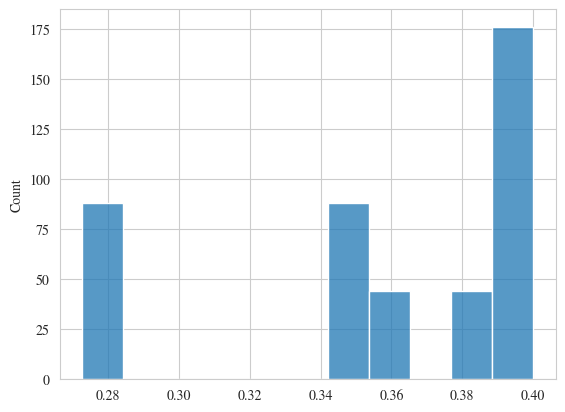

In [85]:
import seaborn as sns
sns.histplot(y_label.flatten())

In [86]:
pd.DataFrame(classes).value_counts()

2    352
1     88
Name: count, dtype: int64

# EEGNet

In [87]:
# OHE labels
y_train = pd.get_dummies(y_train.flatten()).astype(float)
y_test = pd.get_dummies(y_test.flatten()).astype(float)

In [88]:
clf = EEGNet(nb_classes=y_train.shape[1], Chans=tensor.shape[2], Samples=tensor.shape[1], dropoutRate=0.5, kernLength=16, F1=2, D=1, F2=2, norm_rate=0.25, dropoutType='Dropout')
#clf = VanillaDense(nb_classes=y_train.shape[1], Chans=tensor.shape[2], Samples=tensor.shape[1])

clf.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [89]:
clf.summary()

Model: "model_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_79 (InputLayer)       [(None, 7, 250, 1)]       0         
                                                                 
 conv2d_78 (Conv2D)          (None, 7, 250, 2)         32        
                                                                 
 batch_normalization_234 (B  (None, 7, 250, 2)         8         
 atchNormalization)                                              
                                                                 
 depthwise_conv2d_78 (Depth  (None, 1, 250, 2)         14        
 wiseConv2D)                                                     
                                                                 
 batch_normalization_235 (B  (None, 1, 250, 2)         8         
 atchNormalization)                                              
                                                          

In [90]:
losses: list = []
val_losses: list = []
acc: list = []
val_acc: list = []

for i in range(N_RUNS):
    clf = EEGNet(nb_classes=y_train.shape[1], Chans=tensor.shape[2], Samples=tensor.shape[1], dropoutRate=0.5, kernLength=16, F1=2, D=1, F2=2, norm_rate=0.25, dropoutType='Dropout')
    clf.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    #history = clf.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size = 8, epochs = 64, verbose = 2, shuffle=True)
    history = clf.fit(X_train.transpose(0, 2, 1)[:, :, :, np.newaxis], y_train, validation_data=(X_test.transpose(0, 2, 1)[:, :, :, np.newaxis], y_test), batch_size=4, epochs=N_EPOCHS, verbose=2, shuffle=True)

    losses.append(history.history["loss"])
    val_losses.append(history.history["val_loss"])
    acc.append(history.history["accuracy"])
    val_acc.append(history.history["val_accuracy"])

Epoch 1/32
147/147 - 2s - loss: 0.5996 - accuracy: 0.7262 - val_loss: 0.5139 - val_accuracy: 0.7945 - 2s/epoch - 12ms/step
Epoch 2/32
147/147 - 1s - loss: 0.5083 - accuracy: 0.8078 - val_loss: 0.4034 - val_accuracy: 0.7945 - 536ms/epoch - 4ms/step
Epoch 3/32
147/147 - 1s - loss: 0.4424 - accuracy: 0.8707 - val_loss: 0.3756 - val_accuracy: 1.0000 - 637ms/epoch - 4ms/step
Epoch 4/32
147/147 - 1s - loss: 0.4028 - accuracy: 0.8827 - val_loss: 0.3353 - val_accuracy: 1.0000 - 633ms/epoch - 4ms/step
Epoch 5/32
147/147 - 1s - loss: 0.3728 - accuracy: 0.8793 - val_loss: 0.3101 - val_accuracy: 1.0000 - 709ms/epoch - 5ms/step
Epoch 6/32
147/147 - 1s - loss: 0.3678 - accuracy: 0.8793 - val_loss: 0.2876 - val_accuracy: 1.0000 - 698ms/epoch - 5ms/step
Epoch 7/32
147/147 - 1s - loss: 0.3330 - accuracy: 0.8963 - val_loss: 0.2839 - val_accuracy: 1.0000 - 841ms/epoch - 6ms/step
Epoch 8/32
147/147 - 1s - loss: 0.3279 - accuracy: 0.8810 - val_loss: 0.3269 - val_accuracy: 1.0000 - 917ms/epoch - 6ms/step
Ep

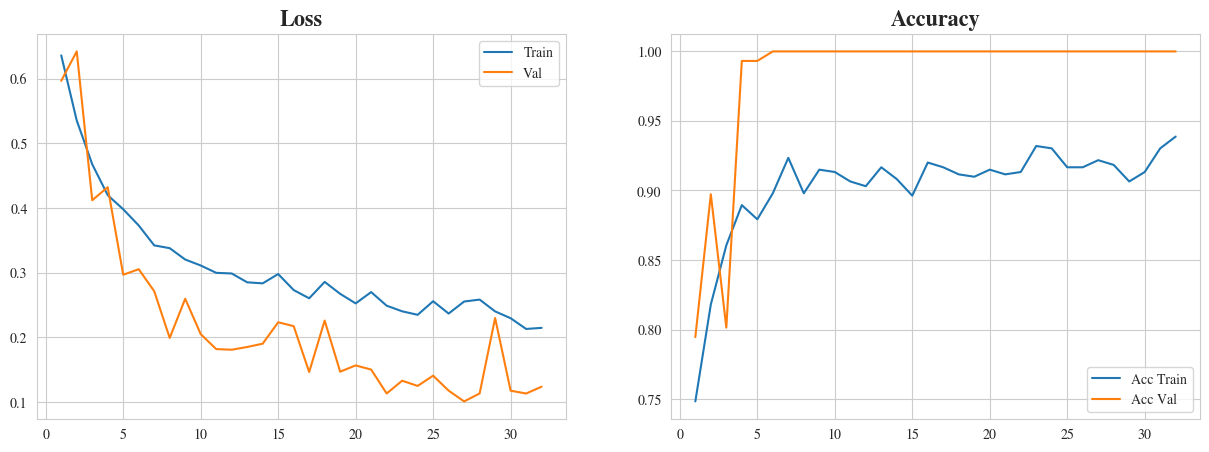

In [91]:
def plot_history(history):
    loss_train = history.history["loss"]
    loss_val = history.history["val_loss"]

    acc_train = history.history["accuracy"]
    acc_val = history.history["val_accuracy"]
    x = [i+1 for i in range(0, len(loss_train))]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    axes[0].set_title("Loss", size=16, fontweight="bold")
    sns.lineplot(x=x, y=loss_train, label="Train", ax=axes[0])
    sns.lineplot(x=x, y=loss_val, label="Val", ax=axes[0])

    axes[1].set_title("Accuracy", size=16, fontweight="bold")
    sns.lineplot(x=x, y=acc_train, label="Acc Train", ax=axes[1])
    sns.lineplot(x=x, y=acc_val, label="Acc Val", ax=axes[1])

plot_history(history)

In [92]:
losses_df = pd.DataFrame(losses)
val_losses_df = pd.DataFrame(val_losses)
acc_df = pd.DataFrame(acc)
val_acc_df = pd.DataFrame(val_acc)

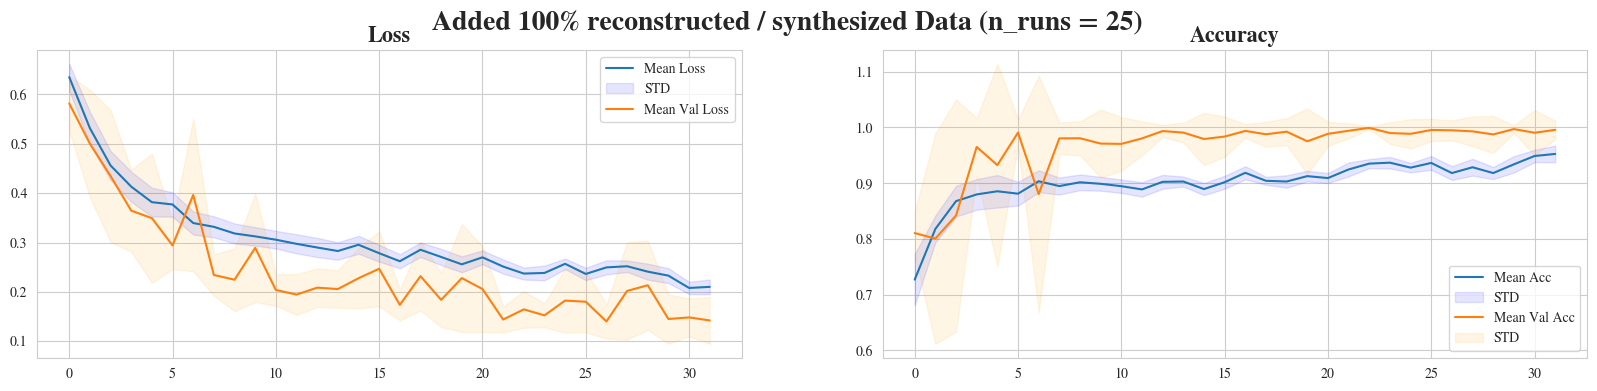

In [93]:
loss_mean = np.mean(losses_df, axis=0)
loss_std = np.std(losses_df, axis=0)
val_loss_mean = np.mean(val_losses_df, axis=0)
val_loss_std = np.std(val_losses_df, axis=0)

acc_mean = np.mean(acc_df, axis=0)
acc_std = np.std(acc_df, axis=0)
val_acc_mean = np.mean(val_acc_df, axis=0)
val_acc_std = np.std(val_acc_df, axis=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
fig.suptitle(f"Added {PERCENTAGE_OF_SYNTHESIZED_DATA_TO_POPULATE_TRAIN * 100}% reconstructed / synthesized Data (n_runs = {N_RUNS})", size=20, fontweight="bold")
sns.lineplot(loss_mean, ax=ax[0], label="Mean Loss")
ax[0].fill_between(range(0, loss_mean.shape[0]), (loss_mean-loss_std), (loss_mean+loss_std), color='b', alpha=.1, label="STD")
sns.lineplot(val_loss_mean, ax=ax[0], label="Mean Val Loss")
ax[0].fill_between(range(0, val_loss_mean.shape[0]), (val_loss_mean-val_loss_std), (val_loss_mean+val_loss_std), color='orange', alpha=.1, label="STD")
ax[0].set_title("Loss", size=16, fontweight="bold")

sns.lineplot(acc_mean, ax=ax[1], label="Mean Acc")
ax[1].fill_between(range(0, acc_mean.shape[0]), (acc_mean-acc_std), (acc_mean+acc_std), color='b', alpha=.1, label="STD")
sns.lineplot(val_acc_mean, ax=ax[1], label="Mean Val Acc")
ax[1].fill_between(range(0, val_acc_mean.shape[0]), (val_acc_mean-val_acc_std), (val_acc_mean+val_acc_std), color='orange', alpha=.1, label="STD")
ax[1].set_title("Accuracy", size=16, fontweight="bold")

plt.legend()
plt.savefig(f"{PERCENTAGE_OF_SYNTHESIZED_DATA_TO_POPULATE_TRAIN}-run-NRUNS-{N_RUNS}.png", bbox_inches='tight', dpi=126)
plt.show()